In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns




In [6]:
import os
import pandas as pd
from processing_utils import run_processing

# Path to the data directory
data_dir = '/Volumes/T9/FOXES_Data/SXR'
csv_path = 'sxr_file_info.csv'


# Use the utility function for multiprocessing (works better on macOS/Jupyter)
df = run_processing(data_dir)
# Save results to avoid re-processing
df.to_csv(csv_path, index=False)

df.head()
            

Listing files in train...
Listing files in val...
Listing files in test...
Total files to process: 194218


Processing files: 100%|██████████| 194218/194218 [14:32<00:00, 222.55it/s]


,filename,split,date,flare_class
0,2012-01-14T13:02:00.npy,train,2012-01-14 13:02:00,M-class
1,2012-01-14T13:05:00.npy,train,2012-01-14 13:05:00,M-class
2,2012-01-14T13:12:00.npy,train,2012-01-14 13:12:00,M-class
3,2012-01-14T13:00:00.npy,train,2012-01-14 13:00:00,M-class
4,2012-01-14T15:20:00.npy,train,2012-01-14 15:20:00,C-class


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from datetime import datetime
import numpy as np
from scipy import stats

# Define the predefined date ranges for each split
buffer_strategy_ranges = {
    'train': [
        (pd.to_datetime("2012-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2022-12-31").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-20").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'val': [
        (pd.to_datetime("2023-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-06-30").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-25").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-30").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'test': [
        (pd.to_datetime("2023-08-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2025-09-01").replace(hour=23, minute=59, second=59, microsecond=999999))
    ]
}


# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Create figure with two subplots (KDE on top, timeline on bottom)
fig, (ax_kde, ax_timeline) = plt.subplots(2, 1, figsize=(16, 8), 
                                           height_ratios=[1, 1.5],
                                           sharex=True)

# Define colors for each split
colors = {
    'train': '#3182ce',
    'val': '#38a169',
    'test': '#e53e3e'
}

# Y-axis positions for each split in timeline
y_positions = {'train': 2, 'val': 1, 'test': 0}

# Get overall date range for KDE
all_dates = []
for ranges in buffer_strategy_ranges.values():
    for start, end in ranges:
        all_dates.extend([start, end])
min_date = min(all_dates)
max_date = max(all_dates)

# Create x-axis for KDE (convert dates to numeric)
x_range = pd.date_range(min_date, max_date, periods=1000)
x_numeric = (x_range - min_date).total_seconds()

# Plot KDE for each split
for split_name in ['train', 'val', 'test']:
    split_df = df[df['split'] == split_name]
    
    if len(split_df) > 1:
        # Convert dates to numeric for KDE
        dates_numeric = (split_df['date'] - min_date).dt.total_seconds()
        
        # Calculate KDE
        kde = stats.gaussian_kde(dates_numeric)
        density = kde(x_numeric)
        
        # Normalize density for better visualization
        density = density / density.max() * 0.8
        
        # Plot KDE
        ax_kde.fill_between(x_range, 0, density, 
                            color=colors[split_name], alpha=0.5, label=split_name.capitalize())
        ax_kde.plot(x_range, density, color=colors[split_name], linewidth=2, alpha=0.8)

# Configure KDE plot
ax_kde.set_ylabel('Density', fontsize=11, weight='bold')
ax_kde.set_title('Data Distribution Timeline with Buffer Strategy', fontsize=16, weight='bold', pad=20)
ax_kde.legend(loc='upper right', fontsize=11)
ax_kde.grid(True, alpha=0.3, linestyle='--', axis='x')
ax_kde.set_facecolor('#f8f9fa')
ax_kde.set_ylim(0, 1)

# Plot timeline bars
for split_name, ranges in buffer_strategy_ranges.items():
    y_pos = y_positions[split_name]
    for start, end in ranges:
        duration = (end - start).total_seconds() / 86400
        
        ax_timeline.barh(y_pos, duration, left=start, height=0.6, 
                        color=colors[split_name], alpha=0.8, 
                        edgecolor='white', linewidth=2)
        
        mid_point = start + (end - start) / 2
        duration_days = (end - start).days + 1
        
        if duration_days > 365:
            label = f"{start.strftime('%Y-%m-%d')}\nto\n{end.strftime('%Y-%m-%d')}"
        else:
            label = f"{start.strftime('%m/%d')}-{end.strftime('%m/%d')}"
        
        ax_timeline.text(mid_point, y_pos, label, 
                        ha='center', va='center', fontsize=9, 
                        color='white', weight='bold')

# Configure timeline axes
ax_timeline.set_yticks([0, 1, 2])
ax_timeline.set_yticklabels(['Test', 'Validation', 'Train'], fontsize=12, weight='bold')
ax_timeline.set_xlabel('Date', fontsize=12, weight='bold')
ax_timeline.set_ylabel('Split', fontsize=11, weight='bold')

# Format x-axis dates
ax_timeline.xaxis.set_major_locator(YearLocator())
ax_timeline.xaxis.set_major_formatter(DateFormatter('%Y'))
ax_timeline.xaxis.set_minor_locator(MonthLocator())
ax_timeline.grid(True, alpha=0.3, linestyle='--', axis='x')

# Set x-axis limits with padding
ax_timeline.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))

# Styling
ax_timeline.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nData Distribution Summary:")
print(f"Total data points: {len(df)}")
for split_name in ['train', 'val', 'test']:
    count = len(df[df['split'] == split_name])
    pct = count / len(df) * 100
    print(f"{split_name.capitalize()}: {count} points ({pct:.1f}%)")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from datetime import datetime
import numpy as np

# Define the predefined date ranges for each split
buffer_strategy_ranges = {
    'train': [
        (pd.to_datetime("2012-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2022-12-31").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-20").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'val': [
        (pd.to_datetime("2023-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-06-30").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-25").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-30").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'test': [
        (pd.to_datetime("2023-08-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2025-09-01").replace(hour=23, minute=59, second=59, microsecond=999999))
    ]
}

# REPLACE THIS WITH YOUR ACTUAL DATAFRAME
# Example: df = pd.read_csv('your_data.csv')
# df['date'] = pd.to_datetime(df['date'])
# For demonstration, create sample data with flare classes:
np.random.seed(42)
sample_data = []
flare_classes = ['Weaker than C', 'C-class', 'M-class', 'X-class']
flare_probs = [0.5, 0.3, 0.15, 0.05]  # Realistic distribution
for split_name, ranges in buffer_strategy_ranges.items():
    for start, end in ranges:
        n_points = int((end - start).days * 0.5)
        dates = pd.date_range(start, end, periods=n_points)
        for date in dates:
            sample_data.append({
                'filename': f'file_{len(sample_data)}.txt', 
                'split': split_name, 
                'date': date,
                'flare_class': np.random.choice(flare_classes, p=flare_probs)
            })
df = pd.DataFrame(sample_data)

# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Define colors
split_colors = {
    'train': '#3182ce',
    'val': '#38a169',
    'test': '#e53e3e'
}

flare_class_order = ['Weaker than C', 'C-class', 'M-class', 'X-class']
y_positions = {'train': 2, 'val': 1, 'test': 0}

# Get overall date range
all_dates = []
for ranges in buffer_strategy_ranges.values():
    for start, end in ranges:
        all_dates.extend([start, end])
min_date = min(all_dates)
max_date = max(all_dates)

# Create figure with subplots for each flare class
n_classes = len(flare_class_order)
fig = plt.figure(figsize=(16, 3 * n_classes + 2))
gs = fig.add_gridspec(n_classes + 1, 1, height_ratios=[1] * n_classes + [1.5], hspace=0.3)

axes_hist = [fig.add_subplot(gs[i]) for i in range(n_classes)]
ax_timeline = fig.add_subplot(gs[n_classes])

# Determine global bin edges for consistent histograms
n_bins = 500
bin_edges = pd.date_range(min_date, max_date, periods=n_bins + 1)

# Plot histogram for each flare class
for idx, flare_class in enumerate(flare_class_order):
    ax = axes_hist[idx]
    flare_df = df[df['flare_class'] == flare_class]
    
    if len(flare_df) > 0:
        for split_name in ['train', 'val', 'test']:
            split_flare_df = flare_df[flare_df['split'] == split_name]
            
            if len(split_flare_df) > 0:
                # Create histogram normalized by total count in this flare class
                counts, _ = np.histogram(split_flare_df['date'], bins=bin_edges)
                counts_normalized = counts / len(flare_df)
                
                # Plot as step histogram
                ax.stairs(counts_normalized, bin_edges, 
                         color=split_colors[split_name], alpha=0.6, 
                         linewidth=1.5, fill=True, label=split_name.capitalize())
    
    # Configure histogram plot
    ax.set_ylabel('Normalized\nCount', fontsize=10, weight='bold')
    ax.set_title(f'{flare_class} (n={len(flare_df)})', fontsize=12, weight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    ax.set_facecolor('#f8f9fa')
    ax.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
    
    # Only show x-axis labels on bottom histogram
    if idx < n_classes - 1:
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(MonthLocator())

# Add main title
fig.suptitle('Data Distribution by Flare Class and Split', fontsize=16, weight='bold', y=0.995)

# Plot timeline bars
for split_name, ranges in buffer_strategy_ranges.items():
    y_pos = y_positions[split_name]
    for start, end in ranges:
        duration = (end - start).total_seconds() / 86400
        
        ax_timeline.barh(y_pos, duration, left=start, height=0.6, 
                        color=split_colors[split_name], alpha=0.8, 
                        edgecolor='white', linewidth=2)
        
        mid_point = start + (end - start) / 2
        duration_days = (end - start).days + 1
        
        if duration_days > 365:
            label = f"{start.strftime('%Y-%m-%d')}\nto\n{end.strftime('%Y-%m-%d')}"
        else:
            label = f"{start.strftime('%m/%d')}-{end.strftime('%m/%d')}"
        
        ax_timeline.text(mid_point, y_pos, label, 
                        ha='center', va='center', fontsize=9, 
                        color='white', weight='bold')

# Configure timeline axes
ax_timeline.set_yticks([0, 1, 2])
ax_timeline.set_yticklabels(['Test', 'Validation', 'Train'], fontsize=12, weight='bold')
ax_timeline.set_xlabel('Date', fontsize=12, weight='bold')
ax_timeline.set_ylabel('Split', fontsize=11, weight='bold')
ax_timeline.set_title('Predefined Split Ranges', fontsize=12, weight='bold', loc='left')

# Format x-axis dates
ax_timeline.xaxis.set_major_locator(YearLocator())
ax_timeline.xaxis.set_major_formatter(DateFormatter('%Y'))
ax_timeline.xaxis.set_minor_locator(MonthLocator())
ax_timeline.grid(True, alpha=0.3, linestyle='--', axis='x')
ax_timeline.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
ax_timeline.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nData Distribution Summary:")
print(f"Total data points: {len(df)}\n")
print("By Split:")
for split_name in ['train', 'val', 'test']:
    count = len(df[df['split'] == split_name])
    pct = count / len(df) * 100
    print(f"  {split_name.capitalize()}: {count} points ({pct:.1f}%)")

print("\nBy Flare Class:")
for flare_class in flare_class_order:
    count = len(df[df['flare_class'] == flare_class])
    pct = count / len(df) * 100
    print(f"  {flare_class}: {count} points ({pct:.1f}%)")

print("\nBy Split and Flare Class:")
for split_name in ['train', 'val', 'test']:
    print(f"\n  {split_name.capitalize()}:")
    split_df = df[df['split'] == split_name]
    for flare_class in flare_class_order:
        count = len(split_df[split_df['flare_class'] == flare_class])
        pct = count / len(split_df) * 100 if len(split_df) > 0 else 0
        print(f"    {flare_class}: {count} points ({pct:.1f}%)")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from datetime import datetime
import numpy as np
from scipy import stats

# Define the predefined date ranges for each split
buffer_strategy_ranges = {
    'train': [
        (pd.to_datetime("2012-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2022-12-31").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-20").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'val': [
        (pd.to_datetime("2023-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-06-30").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-25").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-30").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'test': [
        (pd.to_datetime("2023-08-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2025-09-01").replace(hour=23, minute=59, second=59, microsecond=999999))
    ]
}

# REPLACE THIS WITH YOUR ACTUAL DATAFRAME
# Example: df = pd.read_csv('your_data.csv')
# df['date'] = pd.to_datetime(df['date'])
# For demonstration, create sample data with flare classes:
np.random.seed(42)
sample_data = []
flare_classes = ['Weaker than C', 'C-class', 'M-class', 'X-class']
flare_probs = [0.5, 0.3, 0.15, 0.05]  # Realistic distribution
for split_name, ranges in buffer_strategy_ranges.items():
    for start, end in ranges:
        n_points = int((end - start).days * 0.5)
        dates = pd.date_range(start, end, periods=n_points)
        for date in dates:
            sample_data.append({
                'filename': f'file_{len(sample_data)}.txt', 
                'split': split_name, 
                'date': date,
                'flare_class': np.random.choice(flare_classes, p=flare_probs)
            })
df = pd.DataFrame(sample_data)

# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Define colors
split_colors = {
    'train': '#3182ce',
    'val': '#38a169',
    'test': '#e53e3e'
}

flare_class_order = ['Weaker than C', 'C-class', 'M-class', 'X-class']
y_positions = {'train': 2, 'val': 1, 'test': 0}

# Get overall date range
all_dates = []
for ranges in buffer_strategy_ranges.values():
    for start, end in ranges:
        all_dates.extend([start, end])
min_date = min(all_dates)
max_date = max(all_dates)

# Create x-axis for KDE (convert dates to numeric)
x_range = pd.date_range(min_date, max_date, periods=1000)
x_numeric = (x_range - min_date).total_seconds()

# Create figure with subplots for each flare class
n_classes = len(flare_class_order)
fig = plt.figure(figsize=(16, 3 * n_classes + 2))
gs = fig.add_gridspec(n_classes + 1, 1, height_ratios=[1] * n_classes + [1.5], hspace=0.3)

axes_kde = [fig.add_subplot(gs[i]) for i in range(n_classes)]
ax_timeline = fig.add_subplot(gs[n_classes])

# Plot KDE for each flare class
for idx, flare_class in enumerate(flare_class_order):
    ax = axes_kde[idx]
    flare_df = df[df['flare_class'] == flare_class]
    
    if len(flare_df) > 1:
        for split_name in ['train', 'val', 'test']:
            split_flare_df = flare_df[flare_df['split'] == split_name]
            
            if len(split_flare_df) > 1:
                # Get the ranges for this split to apply hard boundaries
                split_ranges = buffer_strategy_ranges[split_name]
                
                for start_range, end_range in split_ranges:
                    # Filter data to only this specific range
                    range_mask = (split_flare_df['date'] >= start_range) & (split_flare_df['date'] <= end_range)
                    range_df = split_flare_df[range_mask]
                    
                    if len(range_df) > 1:
                        # Convert dates to numeric for KDE
                        dates_numeric = (range_df['date'] - min_date).dt.total_seconds()
                        
                        # Create x-axis only for this range (hard boundary)
                        x_range_split = pd.date_range(start_range, end_range, periods=500)
                        x_numeric_split = (x_range_split - min_date).total_seconds()
                        
                        # Calculate KDE with bandwidth adjustment
                        try:
                            kde = stats.gaussian_kde(dates_numeric, bw_method='scott')
                            density = kde(x_numeric_split)
                            
                            # Normalize density for better visualization
                            if density.max() > 0:
                                density = density / density.max()
                            
                            # Plot KDE only within the range boundaries
                            ax.fill_between(x_range_split, 0, density, 
                                            color=split_colors[split_name], alpha=0.4, 
                                            label=split_name.capitalize() if start_range == split_ranges[0][0] else '')
                            ax.plot(x_range_split, density, color=split_colors[split_name], 
                                   linewidth=2, alpha=0.8)
                        except:
                            # If KDE fails (e.g., too few points), skip
                            pass
    
    # Configure KDE plot
    ax.set_ylabel('Density', fontsize=10, weight='bold')
    ax.set_title(f'{flare_class} (n={len(flare_df)})', fontsize=12, weight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    ax.set_facecolor('#f8f9fa')
    ax.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
    ax.set_ylim(0, 1.1)
    
    # Only show x-axis labels on bottom KDE plot
    if idx < n_classes - 1:
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(MonthLocator())

# Add main title
fig.suptitle('KDE Distribution by Flare Class and Split', fontsize=16, weight='bold', y=0.995)

# Plot timeline bars
for split_name, ranges in buffer_strategy_ranges.items():
    y_pos = y_positions[split_name]
    for start, end in ranges:
        duration = (end - start).total_seconds() / 86400
        
        ax_timeline.barh(y_pos, duration, left=start, height=0.6, 
                        color=split_colors[split_name], alpha=0.8, 
                        edgecolor='white', linewidth=2)
        
        mid_point = start + (end - start) / 2
        duration_days = (end - start).days + 1
        
        if duration_days > 365:
            label = f"{start.strftime('%Y-%m-%d')}\nto\n{end.strftime('%Y-%m-%d')}"
        else:
            label = f"{start.strftime('%m/%d')}-{end.strftime('%m/%d')}"
        
        ax_timeline.text(mid_point, y_pos, label, 
                        ha='center', va='center', fontsize=9, 
                        color='white', weight='bold')

# Configure timeline axes
ax_timeline.set_yticks([0, 1, 2])
ax_timeline.set_yticklabels(['Test', 'Validation', 'Train'], fontsize=12, weight='bold')
ax_timeline.set_xlabel('Date', fontsize=12, weight='bold')
ax_timeline.set_ylabel('Split', fontsize=11, weight='bold')
ax_timeline.set_title('Predefined Split Ranges', fontsize=12, weight='bold', loc='left')

# Format x-axis dates
ax_timeline.xaxis.set_major_locator(YearLocator())
ax_timeline.xaxis.set_major_formatter(DateFormatter('%Y'))
ax_timeline.xaxis.set_minor_locator(MonthLocator())
ax_timeline.grid(True, alpha=0.3, linestyle='--', axis='x')
ax_timeline.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
ax_timeline.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nData Distribution Summary:")
print(f"Total data points: {len(df)}\n")
print("By Split:")
for split_name in ['train', 'val', 'test']:
    count = len(df[df['split'] == split_name])
    pct = count / len(df) * 100
    print(f"  {split_name.capitalize()}: {count} points ({pct:.1f}%)")

print("\nBy Flare Class:")
for flare_class in flare_class_order:
    count = len(df[df['flare_class'] == flare_class])
    pct = count / len(df) * 100
    print(f"  {flare_class}: {count} points ({pct:.1f}%)")

print("\nBy Split and Flare Class:")
for split_name in ['train', 'val', 'test']:
    print(f"\n  {split_name.capitalize()}:")
    split_df = df[df['split'] == split_name]
    for flare_class in flare_class_order:
        count = len(split_df[split_df['flare_class'] == flare_class])
        pct = count / len(split_df) * 100 if len(split_df) > 0 else 0
        print(f"    {flare_class}: {count} points ({pct:.1f}%)")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from datetime import datetime
import numpy as np

# Define the predefined date ranges for each split
buffer_strategy_ranges = {
    'train': [
        (pd.to_datetime("2012-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2022-12-31").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-20").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'val': [
        (pd.to_datetime("2023-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-06-30").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-25").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-30").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'test': [
        (pd.to_datetime("2023-08-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2025-09-01").replace(hour=23, minute=59, second=59, microsecond=999999))
    ]
}

# REPLACE THIS WITH YOUR ACTUAL DATAFRAME
# Example: df = pd.read_csv('your_data.csv')
# df['date'] = pd.to_datetime(df['date'])
# For demonstration, create sample data with flare classes:
np.random.seed(42)
sample_data = []
flare_classes = ['Weaker than C', 'C-class', 'M-class', 'X-class']
flare_probs = [0.5, 0.3, 0.15, 0.05]  # Realistic distribution
for split_name, ranges in buffer_strategy_ranges.items():
    for start, end in ranges:
        n_points = int((end - start).days * 0.5)
        dates = pd.date_range(start, end, periods=n_points)
        for date in dates:
            sample_data.append({
                'filename': f'file_{len(sample_data)}.txt', 
                'split': split_name, 
                'date': date,
                'flare_class': np.random.choice(flare_classes, p=flare_probs)
            })
df = pd.DataFrame(sample_data)

# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Define colors
split_colors = {
    'train': '#3182ce',
    'val': '#38a169',
    'test': '#e53e3e'
}

flare_class_order = ['Weaker than C', 'C-class', 'M-class', 'X-class']
y_positions = {'train': 2, 'val': 1, 'test': 0}

# Get overall date range
all_dates = []
for ranges in buffer_strategy_ranges.values():
    for start, end in ranges:
        all_dates.extend([start, end])
min_date = min(all_dates)
max_date = max(all_dates)

# Create figure with subplots for each flare class
n_classes = len(flare_class_order)
fig = plt.figure(figsize=(16, 3 * n_classes + 2))
gs = fig.add_gridspec(n_classes + 1, 1, height_ratios=[1] * n_classes + [1.5], hspace=0.3)

axes_hist = [fig.add_subplot(gs[i]) for i in range(n_classes)]
ax_timeline = fig.add_subplot(gs[n_classes])

# Determine global bin edges for consistent histograms
n_bins = 100
bin_edges = pd.date_range(min_date, max_date, periods=n_bins + 1)

# Plot histogram for each flare class
for idx, flare_class in enumerate(flare_class_order):
    ax = axes_hist[idx]
    flare_df = df[df['flare_class'] == flare_class]
    
    if len(flare_df) > 0:
        # Calculate bin centers for positioning bars
        bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
        bin_width = (bin_edges[1] - bin_edges[0]).total_seconds() / 86400  # in days
        
        # Calculate bar width for each split (divide bin width by number of splits)
        bar_width_days = bin_width / 3
        bar_width = pd.Timedelta(days=bar_width_days)
        
        # Offset positions for each split to avoid overlap
        offsets = {
            'train': -bar_width,
            'val': pd.Timedelta(days=0),
            'test': bar_width
        }
        
        for split_name in ['train', 'val', 'test']:
            split_flare_df = flare_df[flare_df['split'] == split_name]
            
            if len(split_flare_df) > 0:
                # Create histogram normalized by total count in this flare class
                counts, _ = np.histogram(split_flare_df['date'], bins=bin_edges)
                counts_normalized = counts / len(flare_df)
                
                # Plot as bars with offset
                ax.bar(bin_centers + offsets[split_name], counts_normalized, 
                       width=bar_width_days, color=split_colors[split_name], 
                       alpha=0.7, edgecolor='white', linewidth=0.5,
                       label=split_name.capitalize())
    
    # Configure histogram plot
    ax.set_ylabel('Normalized\nCount', fontsize=10, weight='bold')
    ax.set_title(f'{flare_class} (n={len(flare_df)})', fontsize=12, weight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    ax.set_facecolor('#f8f9fa')
    ax.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
    
    # Only show x-axis labels on bottom histogram
    if idx < n_classes - 1:
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(MonthLocator())

# Add main title
fig.suptitle('Data Distribution by Flare Class and Split', fontsize=16, weight='bold', y=0.995)

# Plot timeline bars
for split_name, ranges in buffer_strategy_ranges.items():
    y_pos = y_positions[split_name]
    for start, end in ranges:
        duration = (end - start).total_seconds() / 86400
        
        ax_timeline.barh(y_pos, duration, left=start, height=0.6, 
                        color=split_colors[split_name], alpha=0.8, 
                        edgecolor='white', linewidth=2)
        
        mid_point = start + (end - start) / 2
        duration_days = (end - start).days + 1
        
        if duration_days > 365:
            label = f"{start.strftime('%Y-%m-%d')}\nto\n{end.strftime('%Y-%m-%d')}"
        else:
            label = f"{start.strftime('%m/%d')}-{end.strftime('%m/%d')}"
        
        ax_timeline.text(mid_point, y_pos, label, 
                        ha='center', va='center', fontsize=9, 
                        color='black', weight='bold')

# Configure timeline axes
ax_timeline.set_yticks([0, 1, 2])
ax_timeline.set_yticklabels(['Test', 'Validation', 'Train'], fontsize=12, weight='bold')
ax_timeline.set_xlabel('Date', fontsize=12, weight='bold')
ax_timeline.set_ylabel('Split', fontsize=11, weight='bold')
ax_timeline.set_title('Predefined Split Ranges', fontsize=12, weight='bold', loc='left')

# Format x-axis dates
ax_timeline.xaxis.set_major_locator(YearLocator())
ax_timeline.xaxis.set_major_formatter(DateFormatter('%Y'))
ax_timeline.xaxis.set_minor_locator(MonthLocator())
ax_timeline.grid(True, alpha=0.3, linestyle='--', axis='x')
ax_timeline.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
ax_timeline.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nData Distribution Summary:")
print(f"Total data points: {len(df)}\n")
print("By Split:")
for split_name in ['train', 'val', 'test']:
    count = len(df[df['split'] == split_name])
    pct = count / len(df) * 100
    print(f"  {split_name.capitalize()}: {count} points ({pct:.1f}%)")

print("\nBy Flare Class:")
for flare_class in flare_class_order:
    count = len(df[df['flare_class'] == flare_class])
    pct = count / len(df) * 100
    print(f"  {flare_class}: {count} points ({pct:.1f}%)")

print("\nBy Split and Flare Class:")
for split_name in ['train', 'val', 'test']:
    print(f"\n  {split_name.capitalize()}:")
    split_df = df[df['split'] == split_name]
    for flare_class in flare_class_order:
        count = len(split_df[split_df['flare_class'] == flare_class])
        pct = count / len(split_df) * 100 if len(split_df) > 0 else 0
        print(f"    {flare_class}: {count} points ({pct:.1f}%)")

In [3]:
import matplotlib.font_manager as fm
from matplotlib import rcParams
def setup_barlow_font():
    """Setup Barlow font for matplotlib plots"""
    try:
        # Try to find Barlow font with more specific search
        barlow_fonts = []
        for font in fm.fontManager.ttflist:
            if 'barlow' in font.name.lower() or 'barlow' in font.fname.lower():
                barlow_fonts.append(font.name)
        
        if barlow_fonts:
            rcParams['font.family'] = 'Barlow'
            print(f"Using Barlow font: {barlow_fonts[0]}")
        else:
            # Try alternative approach - directly specify font file
            barlow_path = '/Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf'
            if os.path.exists(barlow_path):
                # Add the font file directly to matplotlib
                fm.fontManager.addfont(barlow_path)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path}")
            else:
                # Fallback to sans-serif
                rcParams['font.family'] = 'sans-serif'
                print("Barlow font not found, using default sans-serif")
    except Exception as e:
        print(f"Font setup error: {e}, using default font")
setup_barlow_font()

Using Barlow font from: /Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf


/var/folders/7b/12l3h5c96vl3jzd4q_blt1180000gn/T/ipykernel_30737/750941895.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


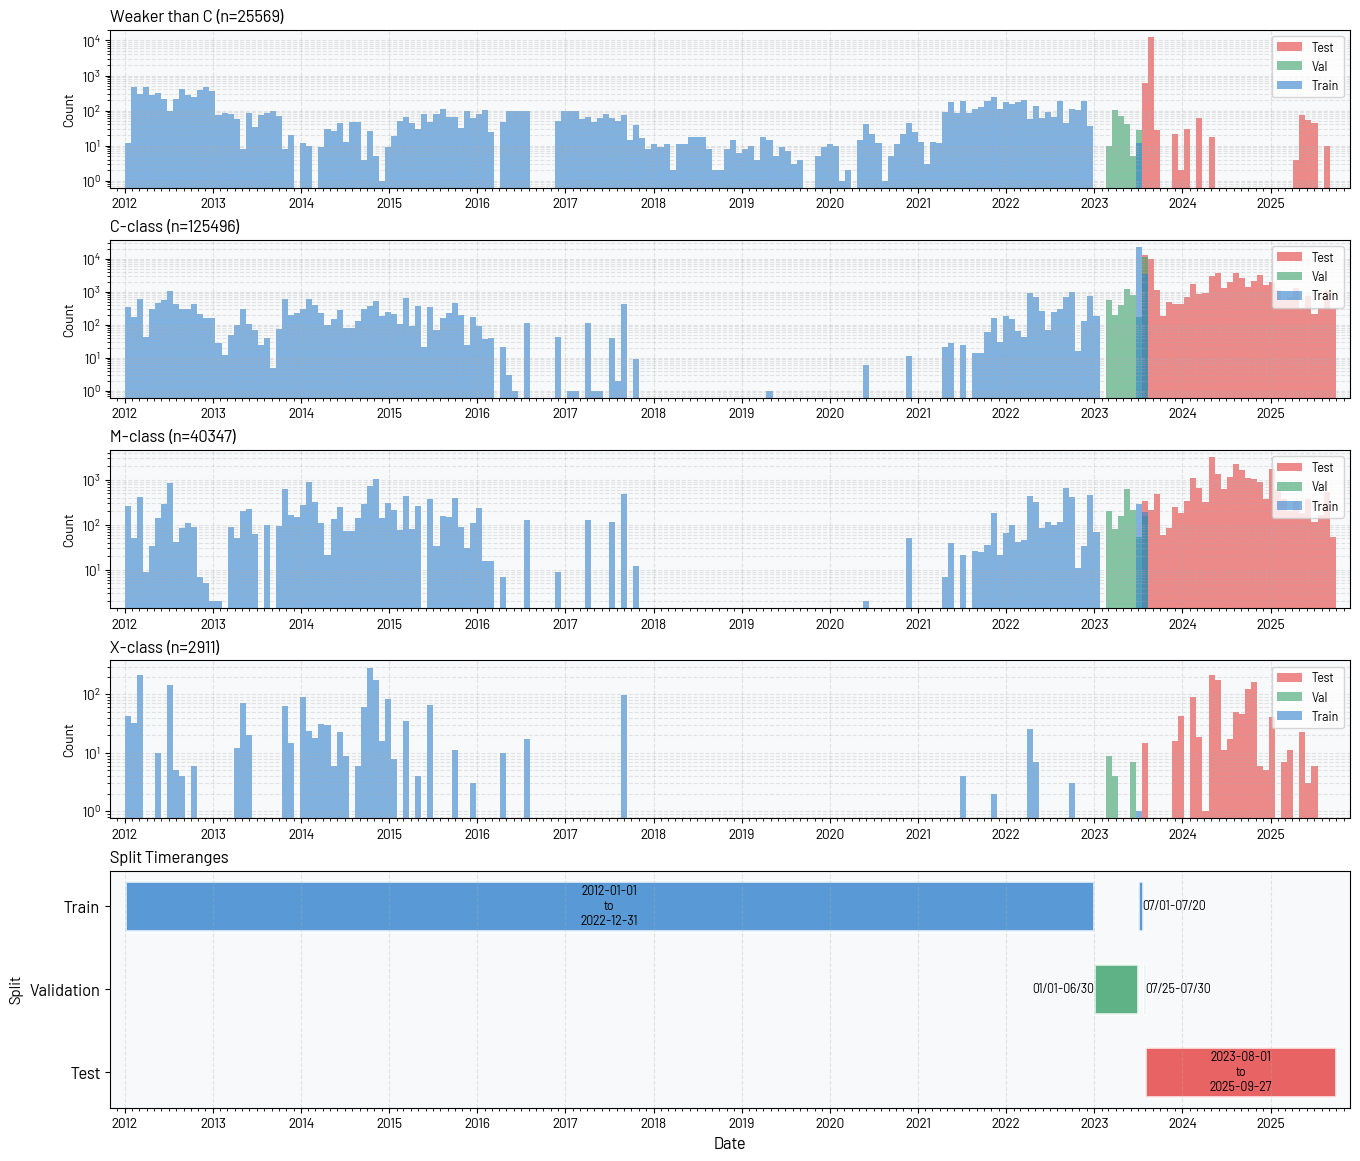


Data Distribution Summary:
Total data points: 194323

By Split:
  Train: 77809 points (40.0%)
  Val: 16317 points (8.4%)
  Test: 100197 points (51.6%)

By Flare Class:
  Weaker than C: 25569 points (13.2%)
  C-class: 125496 points (64.6%)
  M-class: 40347 points (20.8%)
  X-class: 2911 points (1.5%)

By Split and Flare Class:

  Train:
    Weaker than C: 11712 points (15.1%)
    C-class: 47824 points (61.5%)
    M-class: 16469 points (21.2%)
    X-class: 1804 points (2.3%)

  Val:
    Weaker than C: 257 points (1.6%)
    C-class: 14553 points (89.2%)
    M-class: 1487 points (9.1%)
    X-class: 20 points (0.1%)

  Test:
    Weaker than C: 13600 points (13.6%)
    C-class: 63119 points (63.0%)
    M-class: 22391 points (22.3%)
    X-class: 1087 points (1.1%)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from datetime import datetime
import numpy as np

# Set font to Barlow
plt.rcParams['font.family'] = 'Barlow'
plt.rcParams['font.weight'] = 'normal'

# Define the predefined date ranges for each split
buffer_strategy_ranges = {
    'train': [
        (pd.to_datetime("2012-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2022-12-31").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-20").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'val': [
        (pd.to_datetime("2023-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-06-30").replace(hour=23, minute=59, second=59, microsecond=999999)),
        (pd.to_datetime("2023-07-25").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2023-07-30").replace(hour=23, minute=59, second=59, microsecond=999999))
    ],
    'test': [
        (pd.to_datetime("2023-08-01").replace(hour=0, minute=0, second=0, microsecond=0),
         pd.to_datetime("2025-09-27").replace(hour=23, minute=59, second=59, microsecond=999999))
    ]
}

# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Define colors
split_colors = {
    'train': '#3182ce',
    'val': '#38a169',
    'test': '#e53e3e'
}

flare_class_order = ['Weaker than C', 'C-class', 'M-class', 'X-class']
y_positions = {'train': 2, 'val': 1, 'test': 0}

# Get overall date range
all_dates = []
for ranges in buffer_strategy_ranges.values():
    for start, end in ranges:
        all_dates.extend([start, end])
min_date = min(all_dates)
max_date = max(all_dates)

# Create figure with subplots for each flare class
n_classes = len(flare_class_order)
fig = plt.figure(figsize=(16, 3 * n_classes + 2))
gs = fig.add_gridspec(n_classes + 1, 1, height_ratios=[1] * n_classes + [1.5], hspace=0.3)

axes_hist = [fig.add_subplot(gs[i]) for i in range(n_classes)]
ax_timeline = fig.add_subplot(gs[n_classes])

# Determine global bin edges for consistent histograms
n_bins = 200
bin_edges = pd.date_range(min_date, max_date, periods=n_bins + 1)

# Plot histogram for each flare class
for idx, flare_class in enumerate(flare_class_order):
    ax = axes_hist[idx]
    flare_df = df[df['flare_class'] == flare_class]
    
    if len(flare_df) > 0:
        # Calculate bin centers for positioning bars
        bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
        bin_width = (bin_edges[1] - bin_edges[0])
        
        # Plot bars in reverse order so train is on top
        for split_name in ['test', 'val', 'train']:
            split_flare_df = flare_df[flare_df['split'] == split_name]
            
            if len(split_flare_df) > 0:
                # Create histogram with actual counts
                counts, _ = np.histogram(split_flare_df['date'], bins=bin_edges)
                
                # Plot as overlapping bars
                ax.bar(bin_centers, counts, 
                       width=bin_width,
                       color=split_colors[split_name], 
                       alpha=0.6, edgecolor='none',
                       label=split_name.capitalize())
    
    # Configure histogram plot
    ax.set_ylabel('Count', fontsize=10, weight='bold')
    ax.set_yscale('log')
    ax.set_title(f'{flare_class} (n={len(flare_df)})', fontsize=12, weight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', which='both')
    ax.set_facecolor('#f8f9fa')
    ax.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
    
    # Only show x-axis labels on bottom histogram


    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(MonthLocator())

# Add main title
# Plot timeline bars
for split_name, ranges in buffer_strategy_ranges.items():
    y_pos = y_positions[split_name]
    for start, end in ranges:
        duration = (end - start).total_seconds() / 86400
        
        ax_timeline.barh(y_pos, duration, left=start, height=0.6, 
                        color=split_colors[split_name], alpha=0.8, 
                        edgecolor='white', linewidth=2)
        
        mid_point = start + (end - start) / 2
        duration_days = (end - start).days + 1
        
        if duration_days > 365:
            label = f"{start.strftime('%Y-%m-%d')}\nto\n{end.strftime('%Y-%m-%d')}"
            ax_timeline.text(mid_point, y_pos, label, 
                ha='center', va='center', fontsize=9, 
                color='black', weight='bold')
        else:
            label = f"{start.strftime('%m/%d')}-{end.strftime('%m/%d')}"
            if duration_days > 30:
                ax_timeline.text(start, y_pos, label, 
                    ha='right', va='center', fontsize=9, 
                    color='black', weight='bold')
            else:
                ax_timeline.text(end, y_pos, label, 
                    ha='left', va='center', fontsize=9, 
                    color='black', weight='bold')


# Configure timeline axes
ax_timeline.set_yticks([0, 1, 2])
ax_timeline.set_yticklabels(['Test', 'Validation', 'Train'], fontsize=12, weight='bold')
ax_timeline.set_xlabel('Date', fontsize=12, weight='bold')
ax_timeline.set_ylabel('Split', fontsize=11, weight='bold')
ax_timeline.set_title('Split Timeranges', fontsize=12, weight='bold', loc='left')

# Format x-axis dates
ax_timeline.xaxis.set_major_locator(YearLocator())
ax_timeline.xaxis.set_major_formatter(DateFormatter('%Y'))
ax_timeline.xaxis.set_minor_locator(MonthLocator())
ax_timeline.grid(True, alpha=0.3, linestyle='--', axis='x')
ax_timeline.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
ax_timeline.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nData Distribution Summary:")
print(f"Total data points: {len(df)}\n")
print("By Split:")
for split_name in ['train', 'val', 'test']:
    count = len(df[df['split'] == split_name])
    pct = count / len(df) * 100
    print(f"  {split_name.capitalize()}: {count} points ({pct:.1f}%)")

print("\nBy Flare Class:")
for flare_class in flare_class_order:
    count = len(df[df['flare_class'] == flare_class])
    pct = count / len(df) * 100
    print(f"  {flare_class}: {count} points ({pct:.1f}%)")

print("\nBy Split and Flare Class:")
for split_name in ['train', 'val', 'test']:
    print(f"\n  {split_name.capitalize()}:")
    split_df = df[df['split'] == split_name]
    for flare_class in flare_class_order:
        count = len(split_df[split_df['flare_class'] == flare_class])
        pct = count / len(split_df) * 100 if len(split_df) > 0 else 0
        print(f"    {flare_class}: {count} points ({pct:.1f}%)")

/var/folders/7b/12l3h5c96vl3jzd4q_blt1180000gn/T/ipykernel_30737/1582862984.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Data Distribution Summary:
Total data points: 194218

By Split:
  Train: 77809 points (40.1%)
  Val: 16317 points (8.4%)
  Test: 100092 points (51.5%)

By Flare Class:
  Weaker than C: 25569 points (13.2%)
  C-class: 125415 points (64.6%)
  M-class: 40324 points (20.8%)
  X-class: 2910 points (1.5%)

By Split and Flare Class:

  Train:
    Weaker than C: 11712 points (15.1%)
    C-class: 47824 points (61.5%)
    M-class: 16469 points (21.2%)
    X-class: 1804 points (2.3%)

  Val:
    Weaker than C: 257 points (1.6%)
    C-class: 14553 points (89.2%)
    M-class: 1487 points (9.1%)
    X-class: 20 points (0.1%)

  Test:
    Weaker than C: 13600 points (13.6%)
    C-class: 63038 points (63.0%)
    M-class: 22368 points (22.3%)
    X-class: 1086 points (1.1%)


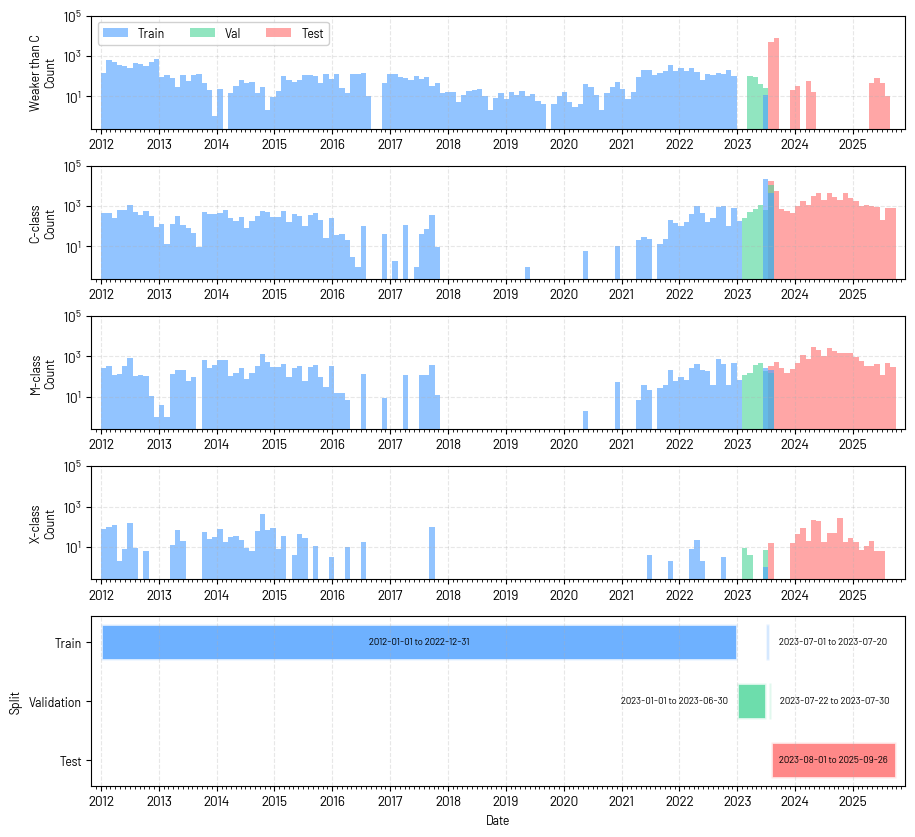

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from datetime import datetime
import numpy as np

plt.rcdefaults()


# Set font to Barlow
plt.rcParams['font.family'] = 'Barlow'
plt.rcParams['font.weight'] = 'normal'

# Dark mode styling
#plt.rcParams['figure.facecolor'] = 'black'
#plt.rcParams['axes.facecolor'] = '#2d2d2d'
#plt.rcParams['axes.edgecolor'] = '#666666'
#plt.rcParams['text.color'] = '#e0e0e0'
#plt.rcParams['axes.labelcolor'] = '#e0e0e0'
#plt.rcParams['xtick.color'] = '#e0e0e0'
#plt.rcParams['ytick.color'] = '#e0e0e0'
#plt.rcParams['grid.color'] = '#444444'

# Define the predefined date ranges for each split
buffer_strategy_ranges = {
            'train': [
                (pd.to_datetime("2012-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
                 pd.to_datetime("2022-12-31").replace(hour=23, minute=59, second=59, microsecond=999999)),
                (pd.to_datetime("2023-07-01").replace(hour=0, minute=0, second=0, microsecond=0),
                 pd.to_datetime("2023-07-20").replace(hour=23, minute=59, second=59, microsecond=999999))
            ],
            'val': [
                (pd.to_datetime("2023-01-01").replace(hour=0, minute=0, second=0, microsecond=0),
                 pd.to_datetime("2023-06-30").replace(hour=23, minute=59, second=59, microsecond=999999)),
                (pd.to_datetime("2023-07-22").replace(hour=0, minute=0, second=0, microsecond=0),
                 pd.to_datetime("2023-07-30").replace(hour=23, minute=59, second=59, microsecond=999999))
            ],
            'test': [
                (pd.to_datetime("2023-08-01").replace(hour=0, minute=0, second=0, microsecond=0),
                 pd.to_datetime("2025-09-26").replace(hour=23, minute=59, second=59, microsecond=999999))
            ]
        }

# REPLACE THIS WITH YOUR ACTUAL DATAFRAME
# Example: df = pd.read_csv('your_data.csv')
# df['date'] = pd.to_datetime(df['date'])
# For demonstration, create sample data with flare classes:


# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Define colors - brighter for dark background
split_colors = {
    'train': '#4a9eff',
    'val': '#48d597',
    'test': '#ff6b6b'
}

flare_class_order = ['Weaker than C', 'C-class', 'M-class', 'X-class']
y_positions = {'train': 2, 'val': 1, 'test': 0}

# Get overall date range
all_dates = []
for ranges in buffer_strategy_ranges.values():
    for start, end in ranges:
        all_dates.extend([start, end])
min_date = min(all_dates)
max_date = max(all_dates)

# Create figure with subplots for each flare class
n_classes = len(flare_class_order)
fig = plt.figure(figsize=(10.5, 2 * n_classes + 2))
gs = fig.add_gridspec(n_classes + 1, 1, height_ratios=[1] * n_classes + [1.5], hspace=0.3)

axes_hist = [fig.add_subplot(gs[i]) for i in range(n_classes)]
ax_timeline = fig.add_subplot(gs[n_classes])

# Determine global bin edges for consistent histograms
n_bins = 150
bin_edges = pd.date_range(min_date, max_date, periods=n_bins + 1)

# Plot histogram for each flare class
for idx, flare_class in enumerate(flare_class_order):
    ax = axes_hist[idx]
    flare_df = df[df['flare_class'] == flare_class]
    
    if len(flare_df) > 0:
        # Calculate bin centers for positioning bars
        bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
        bin_width = (bin_edges[1] - bin_edges[0])
        
        # Plot bars in reverse order so train is on top
        for split_name in ['test', 'val', 'train']:
            split_flare_df = flare_df[flare_df['split'] == split_name]
            
            if len(split_flare_df) > 0:
                # Create histogram with actual counts
                counts, _ = np.histogram(split_flare_df['date'], bins=bin_edges)
                
                # Plot as overlapping bars
                ax.bar(bin_centers, counts, 
                       width=bin_width,
                       color=split_colors[split_name], 
                       alpha=0.6, edgecolor='none',
                       label=split_name.capitalize())
    
    # Configure histogram plot

    #set y axis label to flare class
    ax.set_ylabel(flare_class+"\nCount", fontsize=9, weight='bold')
    
    
    ax.set_yscale('log')
    #ax.set_title(f'{flare_class} (n={len(flare_df)})', fontsize=12, weight='bold', loc='left', color='#e0e0e0')
    
    # To set legend order: grab handles/labels and reorder as desired
    handles, labels = ax.get_legend_handles_labels()
    order = ['Train', 'Val', 'Test']
    ordered = [handles[labels.index(name)] for name in order if name in labels]
    ordered_labels = [name for name in order if name in labels]
    if idx == 0:
        ax.legend(ordered, ordered_labels, loc='upper left', ncol=3, fontsize=9, 
              framealpha=0.9)
    #change legend order
    #ax.legend(handles=ax.legend.legendHandles[::-1], labels=ax.legend.legendLabels[::-1], loc='upper left', ncol=3, fontsize=9, framealpha=0.9, facecolor='#2d2d2d', edgecolor='#666666')
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', which='both')
    #turn off minor y grid
    ax.grid(False, axis='y', which='minor')
    #ax.set_facecolor('#2d2d2d')
    ax.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
    
    # Only show x-axis labels on bottom histogram

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.set_ylim(.25, 1e5)


# Add main title

for split_name, ranges in buffer_strategy_ranges.items():
    y_pos = y_positions[split_name]
    for start, end in ranges:
        duration = (end - start).total_seconds() / 86400
        
        ax_timeline.barh(y_pos, duration, left=start, height=0.6, 
                        color=split_colors[split_name], alpha=0.8, 
                        edgecolor='white', linewidth=2)
        
        mid_point = start + (end - start) / 2
        duration_days = (end - start).days + 1
        
        if duration_days > 365:
            label = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"
            ax_timeline.text(mid_point, y_pos, label, 
                ha='center', va='center', fontsize=7, 
                color='black', weight='bold')
        else:
            label = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"
            if duration_days > 30:
                ax_timeline.text(start-pd.Timedelta(days=60), y_pos, label, 
                    ha='right', va='center', fontsize=7, 
                    color='black', weight='bold')
            else:
                ax_timeline.text(end + pd.Timedelta(days=60), y_pos, label, 
                    ha='left', va='center', fontsize=7, 
                    color='black', weight='bold')

# Configure timeline axes
ax_timeline.set_yticks([0, 1, 2])
ax_timeline.set_yticklabels(['Test', 'Validation', 'Train'], fontsize=9, weight='bold')
ax_timeline.set_xlabel('Date', fontsize=9, weight='bold')
ax_timeline.set_ylabel('Split', fontsize=9, weight='bold')
#ax_timeline.set_title('Split Timeranges', fontsize=12, weight='bold', loc='left')

# Format x-axis dates
ax_timeline.xaxis.set_major_locator(YearLocator())
ax_timeline.xaxis.set_major_formatter(DateFormatter('%Y'))
ax_timeline.xaxis.set_minor_locator(MonthLocator())
ax_timeline.grid(True, alpha=0.3, linestyle='--', axis='x')
ax_timeline.set_xlim(min_date - pd.Timedelta(days=60), max_date + pd.Timedelta(days=60))
#ax_timeline.set_facecolor('#2d2d2d')

#fig.patch.set_facecolor('white')
plt.tight_layout()


# Print summary statistics
print("\nData Distribution Summary:")
print(f"Total data points: {len(df)}\n")
print("By Split:")
for split_name in ['train', 'val', 'test']:
    count = len(df[df['split'] == split_name])
    pct = count / len(df) * 100
    print(f"  {split_name.capitalize()}: {count} points ({pct:.1f}%)")

print("\nBy Flare Class:")
for flare_class in flare_class_order:
    count = len(df[df['flare_class'] == flare_class])
    pct = count / len(df) * 100
    print(f"  {flare_class}: {count} points ({pct:.1f}%)")

print("\nBy Split and Flare Class:")
for split_name in ['train', 'val', 'test']:
    print(f"\n  {split_name.capitalize()}:")
    split_df = df[df['split'] == split_name]
    for flare_class in flare_class_order:
        count = len(split_df[split_df['flare_class'] == flare_class])
        pct = count / len(split_df) * 100 if len(split_df) > 0 else 0
        print(f"    {flare_class}: {count} points ({pct:.1f}%)")

plt.savefig('timelineplot.png', dpi=500, bbox_inches='tight')
plt.show()